In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from data.bt_dataset import BrainTumorDataset
from model2 import BrainTumorCNN
from torch.utils.data import DataLoader, Subset
import torchvision
import torch
import os
import cv2
from data.preprocessing import *
from train import train
from evaluate import evaluate
from torch.optim.lr_scheduler import StepLR

In [58]:
if torch.cuda.is_available():
    print("Working on: GPU")
    device = 'cuda'
else:
    print("Working on: CPU")
    device = 'cpu'

Working on: GPU


### Defining constants:

In [59]:
IMAGE_SIZE = 256
NUM_OF_CLASSES = 4
train_batch_size = test_batch_size = 64
dataset_path = os.path.join(os.getcwd(), 'data')

### Preprocessing:

In [60]:
# Resizing the images and sharpening them:
preprocessing_ops = [resize([IMAGE_SIZE, IMAGE_SIZE]), sharpen()]

### Defining the dataset:

In [61]:
# Defining the Dataset object:
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=preprocessing_ops)

# Defining the DataLoader object:
train_loader = DataLoader(dataset, batch_size=train_batch_size)

### Model specifications:

In [62]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-4
weight_decay = 1e-1
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [63]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

## Overfitting the model in order to test it

In [64]:
overfitting_set_size = 15
overfitting_set = Subset(dataset, list(range(overfitting_set_size)))
overfitting_loader = DataLoader(overfitting_set)

In [65]:
epochs = 5

In [66]:
# scheduler = None
total_loss, epoch_times, accuracies_train, _ = train(model=model, train_loader=overfitting_loader,
                                                                   test_loader=overfitting_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 15/15 [00:00<00:00, 39.92it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 0 | Loss: 3.09
Epoch: 0 took: 0.78 seconds


100%|██████████| 15/15 [00:00<00:00, 23.39it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 1 | Loss: 1.49
Epoch: 1 took: 1.04 seconds


100%|██████████| 15/15 [00:00<00:00, 68.93it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 2 | Loss: 0.65
Epoch: 2 took: 0.52 seconds


100%|██████████| 15/15 [00:00<00:00, 73.75it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 3 | Loss: 0.42
Epoch: 3 took: 0.56 seconds


100%|██████████| 15/15 [00:00<00:00, 43.49it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 4 | Loss: 0.32
Epoch: 4 took: 0.60 seconds


### Plotting the loss:

In [67]:
import matplotlib.pyplot as plt

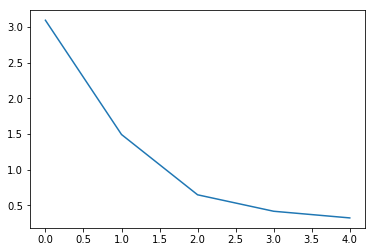

In [68]:
plt.plot(total_loss)
plt.show()

### Plotting train accuracy:

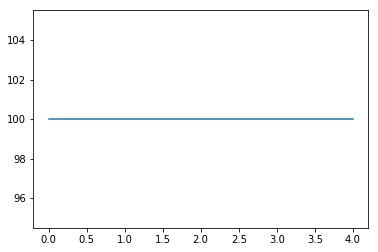

In [69]:
plt.plot(accuracies_train)
plt.show()

In [70]:
accuracy = evaluate(model=model, test_loader=overfitting_loader)
print(f'Overfitting Accuracy: {accuracy:.2f}%')

Overfitting Accuracy: 100.00%


In [98]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-5
weight_decay = 1e-7
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

### Training the model

In [99]:
# Defining the Dataset object:
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=preprocessing_ops, test=True)

# Defining the DataLoader object:
test_loader = DataLoader(dataset, batch_size=train_batch_size)

In [100]:
scheduler = StepLR(optimizer, step_size=2, gamma=1.2)

In [101]:
epochs = 10

In [102]:
# scheduler = None
total_loss, epoch_times, accuracies_train, accuracies_test = train(model=model, train_loader=train_loader,
                                                                   test_loader=test_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


Evaluating epoch...
Learning rate: 1e-05
Epoch: 0 | Loss: 108.03
Epoch: 0 took: 47.51 seconds


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Evaluating epoch...
Learning rate: 1e-05
Epoch: 1 | Loss: 69.41
Epoch: 1 took: 41.87 seconds


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Evaluating epoch...
Learning rate: 1.2e-05
Epoch: 2 | Loss: 67.15
Epoch: 2 took: 41.62 seconds


100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


Evaluating epoch...
Learning rate: 1.2e-05
Epoch: 3 | Loss: 64.97
Epoch: 3 took: 41.46 seconds


100%|██████████| 45/45 [00:18<00:00,  2.40it/s]


Evaluating epoch...
Learning rate: 1.44e-05
Epoch: 4 | Loss: 64.57
Epoch: 4 took: 42.40 seconds


100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


Evaluating epoch...
Learning rate: 1.44e-05
Epoch: 5 | Loss: 63.90
Epoch: 5 took: 40.35 seconds


100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Evaluating epoch...
Learning rate: 1.7279999999999997e-05
Epoch: 6 | Loss: 64.22
Epoch: 6 took: 42.08 seconds


100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


Evaluating epoch...
Learning rate: 1.7279999999999997e-05
Epoch: 7 | Loss: 63.90
Epoch: 7 took: 42.41 seconds


100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Evaluating epoch...
Learning rate: 2.0735999999999996e-05
Epoch: 8 | Loss: 64.45
Epoch: 8 took: 41.76 seconds


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Evaluating epoch...
Learning rate: 2.0735999999999996e-05
Epoch: 9 | Loss: 64.20
Epoch: 9 took: 40.62 seconds


### Plotting the loss:

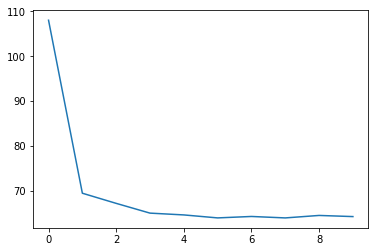

In [103]:
plt.plot(total_loss)
plt.show()

### Plotting train and test accuracies:

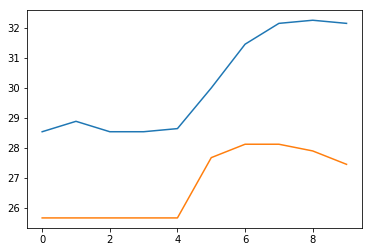

In [104]:
plt.plot(accuracies_train)
plt.plot(accuracies_test)
plt.show()

### Evaluating the model:

In [105]:
accuracy = evaluate(model=model, test_loader=test_loader)

In [106]:
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 27.46%


In [107]:
accuracy = evaluate(model=model, test_loader=train_loader)

In [108]:
print(f'Train Accuracy: {accuracy:.2f}%')

Train Accuracy: 32.15%
